## Initialization

In [1]:
# Import libraries

import numpy as np
import gymnasium as gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import pdb
from copy import deepcopy

In [2]:
# Cartpole environment

env = gym.make("CartPole-v1", render_mode="rgb_array")

## Deep Q Learning

In [3]:
# Make a wrapper class for episode frames

class Frame:
    '''
    Wrapper for frames of each episode
    '''
    state = None         # current state
    action = None        # action
    reward = 0           # reward
    next_state = None    # next state
    terminated = False   # termination flag
    
    def __init__(self, state, action, next_state, reward, terminated):
        '''
        Constructs this frame object
        INPUT
            state; current state
            action; taken action
            reward; received reward
            next_state; next state
            termination; boolean termination flag
        '''
        self.state = state
        self.action = action
        self.next_state = next_state
        self.reward = reward
        self.terminated = terminated
                        
            
# Define capacitated queue for replay memory.            
            
class CapacitatedQueue:
    '''
    A queue with maximum capacity. If any items are added when at capacity, then oldest items are pushed out.
    '''
    collection = []  # items in this collection
    capacity = 128   # max capacity
    next_ind = 0     # index of the next item to be added
    
    def __init__(self, capacity=128):
        '''
        Intializes this model
        INPUT
            capacity; the maximum capacity of this colleciotn
        '''
        self.capacity = capacity
        self.next_ind = 0
        self.collection = []
        
    def __len__():
        '''
        RETURNS length of the collection
        '''
        return len(self.collection)
        
    def add(self, item):
        '''
        Adds the given item into the collection.
        If the collection is at capacity, push out oldest item
        '''
        # If not at capacity, add in item
        if len(self.collection) < self.capacity:
            self.collection.append(item)
            
        # If at capacity, replace oldest item
        else:
            self.collection[self.next_ind] = item
            
        # Track the index of the next/oldest item
        self.next_ind = (self.next_ind + 1) % self.capacity

    def sample(self, size=1):
        '''
        RETURNS a (with-replacement) sample of the given size from the collection
        '''
        return np.random.choice(self.collection, size, replace=True).tolist()
    
    def get_next(self):
        '''
        RETURNS the next item in the collection
        '''
        return self.collection[(next_ind - 1) % self.capacity]

In [4]:
# Construct class for deep-q learning model
    
class DeepQLearner:
    '''
    Class for a Deep-Q learning model
    '''
    env = None                             # associated envionment
    q_estimator = None                     # the fitted function to estimate Q, like a neural network
    state_processor = lambda state: state  # function for converting the environment states into approximator inputs (e.g. a one-hot-encoder)
    
    def __init__(self, env, q_estimator, state_processor=(lambda state:state)):
        '''
        Intializes this object
        INPUT
            env; environment
            q_estimator; trainable function to estimate Q
            state_processor; function for converting the environment states into approximator inputs
        '''
        self.env = env
        self.q_estimator = q_estimator
        self.state_processor = state_processor
        
    def get_action(self, state, epsilon=0.):
        '''
        Gets the action to take
        INPUT
            state; the current state, as would be input to the Q approximator
            epsilon; the epsilon-greedy parameter
                if 0; plays full greedy
                if -1; plays soft-max
        RETURNS
            action to take
        '''
        # Explore
        if (epsilon > 0) and (np.random.uniform() < epsilon):
            return self.env.action_space.sample()
        
        # Softmax
        elif epsilon == -1:
            probs = np.exp(self.q_estimator.predict(state.reshape(1, -1), verbose=0))
            probs = probs / np.sum(probs)
            return np.random.choice(self.env.action_space.n, p=probs.reshape(-1,))
        
        # Greedy
        return np.argmax(self.q_estimator.predict(state.reshape(1, -1), verbose=0))
            
    def train(self, n_steps=10**3, epsilon=0.2, training_delay=32, batch_size=32, discount_factor=1., replay_capacity=128):
        '''
        Trains this model
        INPUT
            n_steps; number of steps to train
            epsilon; epsilon-greedy threshold
            training_delay; number of steps to train before fitting approximator
            batch_size; number of frames to train approximator with
            discount_factor; discount factor in bellman
            replay_capacity; the capacity of the replay memory
        RETURNS
            list of episode rewards
        '''
        # Initialize
        replay_memory = CapacitatedQueue(replay_capacity)
        episode_counter = 0
        delay_counter = 0
        reward_history = [0]
        
        # First state
        state, _ = self.env.reset()
        state = self.state_processor(state)
        
        # Train for each step
        pbar = tqdm(range(n_steps))
        for _ in pbar:
            
            # Get action
            action = self.get_action(state, epsilon)
            
            # Make step
            next_state, reward, terminated, _, _ = self.env.step(action)
            next_state = self.state_processor(next_state)
            
            # Save frame
            replay_memory.add(Frame(state, action, next_state, reward, terminated))
            reward_history[-1] += reward

            # If terminated, record reward and reset
            if terminated:
                state, _ = self.env.reset()
                state = self.state_processor(state)
                pbar.set_description(f"Last episode reward: {reward_history[-1]}")
                pbar.update()
                reward_history.append(0)
            else:
                state = next_state
                
            # If training_delay steps have occurred, then train
            delay_counter += 1
            if delay_counter >= training_delay:
                delay_counter = 0
                
                # Get minibatch params
                frame_batch = replay_memory.sample(batch_size)
                states = np.array([frame.state for frame in frame_batch])
                actions = np.array([frame.action for frame in frame_batch])
                rewards = np.array([frame.reward for frame in frame_batch], dtype=float)
                next_states = np.array([frame.next_state for frame in frame_batch]).reshape(batch_size, -1)
                nonterminateds = (1 - np.array([frame.terminated for frame in frame_batch])).astype(bool)
                
                # Get training targets                
                targets = self.q_estimator.predict(states, verbose=0)
                targets[range(batch_size), actions] = rewards
                if np.sum(nonterminateds):
                    targets[nonterminateds, actions[nonterminateds]] += discount_factor * np.max(self.q_estimator.predict(next_states[nonterminateds, :], verbose=0), axis=1)

                # Train
                self.q_estimator.fit(states, targets, epochs=1, verbose=0)
        
        return reward_history
    
    def play(self, render=True, iter_cutoff=500, epsilon=0.):
        '''
        Plays an episode
        INPUT
            render; whether to show animation
            iter_cutoff; number of steps before truncating episode
            epsilon; epsilon parameter for action selection
        RETURNS
            list of states
        '''
        # Initialize
        state, _ = self.env.reset()
        states = [dql.state_processor(state)]
        frames = [env.render()]
        terminated = False
        iter_counter = 0
        
        # Play episode
        while not terminated and iter_counter < iter_cutoff:
            iter_counter += 1
            action = self.get_action(states[-1], epsilon)
            next_state, _, terminated, _, _ = self.env.step(action)
            states.append(self.state_processor(next_state))
            
            # Record animation frame
            if render:
                frame = self.env.render()
                frames.append(frame)
            
        # Show animation
        if render:
            # Make subplots
            fig, ax = plt.subplots()

            # Function to update the figure with the new frame
            def update(frame):
                ax.clear()  # Clear previous frame
                ax.imshow(frame)  # Display the current frame
                return ax,

            # Creating the animation
            ani = FuncAnimation(fig, update, frames=frames, blit=False, interval=50)
            plt.show()
        return states


In [5]:
# Build model
model = Sequential([
    Input(shape=env.observation_space.shape),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(env.action_space.n, activation='linear')
])
model.compile(loss='mse', optimizer='adam')
model.summary()

# Train
dql = DeepQLearner(env, model)
reward_history_q = []
reward_history_q += dql.train(n_steps=10*10**3, epsilon=1., batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history_q += dql.train(n_steps=5*10**3, epsilon=.1, batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history_q += dql.train(n_steps=5*10**3, epsilon=0., batch_size=64, training_delay=8, replay_capacity=10**4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
_________________________________________________________________


Last episode reward: 47.0: 100%|██████████| 5000/5000 [04:49<00:00, 17.25it/s] 


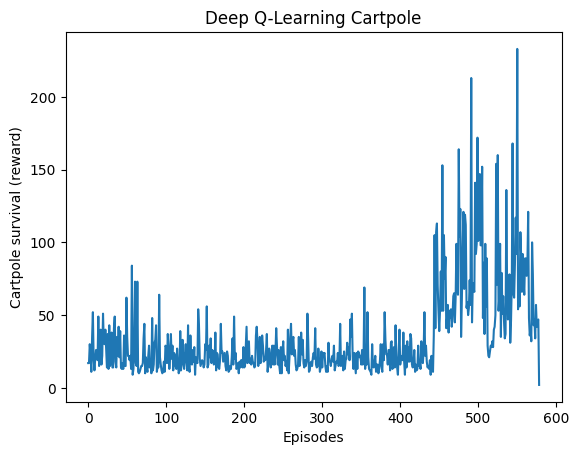

In [6]:
plt.plot(reward_history_q)
plt.xlabel("Episodes")
plt.ylabel("Cartpole survival (reward)")
plt.title("Deep Q-Learning Cartpole")
plt.show()

## Deep V Learning

In [8]:
# Construct class for deep v-learning

class DeepVLearner:
    '''
    Class for constructing a deep V-learning model
    
    WORKS BEST FOR DETERMINISTIC ENVIRONMENTS, like cartpole (physics problems have deterministic outcomes) or go (no-luck boardgame)
    '''
    
    env = None                             # associated envionment
    v_estimator = None                     # the fitted function to estimate V, like a neural network
    state_processor = lambda state: state  # function for converting the environment states into approximator inputs (e.g. a one-hot-encoder)
    
    def __init__(self, env, v_estimator, state_processor=(lambda state:state)):
        '''
        Intializes this object
        INPUT
            env; environment
            v_estimator; trainable function to estimate V
            state_processor; function for converting the environment states into approximator inputs
        '''
        self.env = env
        self.v_estimator = v_estimator
        self.state_processor = state_processor
        
    def get_action(self, state, epsilon=0., discount_factor=1.):
        '''
        Gets the action to take
        INPUT
            state; the current state, as would be input to the Q approximator
            epsilon; the epsilon-greedy parameter
                if 0; plays full greedy
                if -1; plays soft-max
            discount_factor; amount to discount the value of next state when computing greedy action selection
        RETURNS
            action to take
        '''
        # Explore
        if (epsilon > 0) and (np.random.uniform() < epsilon):
            return self.env.action_space.sample()
        
        # Softmax
        elif epsilon == -1:
            probs = np.exp(self.v_estimator.predict(state.reshape(1, -1), verbose=0))
            probs = probs / np.sum(probs)
            return np.random.choice(self.env.action_space.n, p=probs.reshape(-1,))
        
        # Greedy
        next_states = []
        rewards = []
        terminateds = []
        
        # Lookahead for each action's outcome
        # WORKS BEST IF OUTCOME IS DETERMINISTIC
        for act in range(self.env.action_space.n):
            lookahead_env = deepcopy(self.env)
            next_state, reward, terminated, _, _ = lookahead_env.step(act)
            next_state = self.state_processor(next_state)
            next_states.append(next_state)
            rewards.append(reward)
            terminateds.append(terminated)
        
        # Save outcomes as arrays
        next_states = np.array(next_states).reshape(self.env.action_space.n, -1)
        nonterminateds = (1 - np.array(terminateds)).astype(bool)            
        
        # Bootstrap the value of the next states
        action_values = np.array(rewards, dtype=float)
        if np.sum(nonterminateds):
            action_values[nonterminateds] += discount_factor * self.v_estimator.predict(next_states[nonterminateds], verbose=0)[:, 0]
        
        return np.argmax(action_values)
            
    def train(self, n_steps=10**3, epsilon=0.2, training_delay=32, batch_size=32, discount_factor=1., replay_capacity=128):
        '''
        Trains this model
        INPUT
            n_steps; number of steps to train
            epsilon; epsilon-greedy threshold
            training_delay; number of steps to train before fitting approximator
            batch_size; number of frames to train approximator with
            discount_factor; discount factor in bellman
            replay_capacity; the capacity of the replay memory
        RETURNS
            list of episode rewards
        '''
        # Initialize
        replay_memory = CapacitatedQueue(replay_capacity)
        episode_counter = 0
        delay_counter = 0
        reward_history = [0]
        
        # First state
        state, _ = self.env.reset()
        state = self.state_processor(state)
        
        # Train for each step
        pbar = tqdm(range(n_steps))
        for _ in pbar:
            
            # Get action
            action = self.get_action(state, epsilon)
            
            # Make step
            next_state, reward, terminated, _, _ = self.env.step(action)
            next_state = self.state_processor(next_state)
            
            # Save frame
            replay_memory.add(Frame(state, action, next_state, reward, terminated))
            reward_history[-1] += reward

            # If terminated, record reward and reset
            if terminated:
                state, _ = self.env.reset()
                state = self.state_processor(state)
                pbar.set_description(f"Last episode reward: {reward_history[-1]}")
                pbar.update()
                reward_history.append(0)
            else:
                state = next_state
                
            # If training_delay steps have occurred, then train
            delay_counter += 1
            if delay_counter >= training_delay:
                delay_counter = 0
                
                # Get minibatch params
                frame_batch = replay_memory.sample(batch_size)
                states = np.array([frame.state for frame in frame_batch])
                rewards = np.array([frame.reward for frame in frame_batch], dtype=float)
                next_states = np.array([frame.next_state for frame in frame_batch]).reshape(batch_size, -1)
                nonterminateds = (1 - np.array([frame.terminated for frame in frame_batch])).astype(bool)
                
                # Get training targets
                targets = rewards
                if np.sum(nonterminateds):
                    targets[nonterminateds] += discount_factor * self.v_estimator.predict(next_states[nonterminateds], verbose=0)[:, 0]
                
                # Train
                self.v_estimator.fit(states, targets, epochs=1, verbose=0)
        
        return reward_history

In [9]:
# Build model
model = Sequential([
    Input(shape=(env.observation_space.shape)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')
model.summary()
    
# Train    
dvl = DeepVLearner(env, model)
reward_history_v = []
reward_history_v += dvl.train(n_steps=10*10**3, epsilon=1., batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history_v += dvl.train(n_steps=5*10**3, epsilon=.1, batch_size=64, training_delay=8, replay_capacity=10**4)
reward_history_v += dvl.train(n_steps=5*10**3, epsilon=0., batch_size=64, training_delay=8, replay_capacity=10**4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               1280      
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,305
Trainable params: 34,305
Non-trainable params: 0
_________________________________________________________________


Last episode reward: 186.0: 100%|██████████| 5000/5000 [04:25<00:00, 18.80it/s]


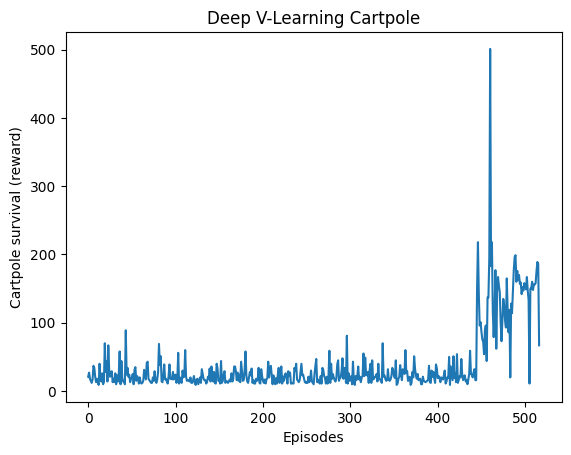

In [10]:
plt.plot(reward_history_v)
plt.xlabel("Episodes")
plt.ylabel("Cartpole survival (reward)")
plt.title("Deep V-Learning Cartpole")
plt.show()